# Compute inundation percent for waterbodies across time

This notebook demonstrates how to load Landsat time series data, identify water pixels using the WOFS algorithm, compute the max extent of water, and calculate the inundation percent compared to max extent for each individual waterbody. This metric can be plotted spatially for different time periods to potentially reveal the impacts of drought across time and space.

**Author**: Robbi Bishop-Taylor

**Date**: 30 October 2018

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
from rasterio.features import shapes
from shapely import geometry
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
from skimage import measure
from skimage import filters
import numpy as np
import matplotlib.pyplot as plt

from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.ama_utils.dc_display_map import display_map
from utils.data_cube_utilities.ama_utils.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.ama_utils.dc_utilities import ignore_warnings

dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')


## Set up analysis

In [2]:
platform = "LANDSAT_8"
product = "ls8_lasrc_tanzania"

In [12]:
# Area with water
# latitude_extents = (-3.24, -5.13)
# longitude_extents = (33.97, 36.6)
latitude_extents = (-4.48, -4.88)
longitude_extents = (34.7, 35.05)
time_extents = ('2013-01-01', '2018-11-01')

In [13]:
display_map(latitude_extents, longitude_extents)

## Import data

In [14]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'], 
                          time = time_extents,
                          group_by = 'solar_day')
landsat_dataset


<xarray.Dataset>
Dimensions:    (latitude: 1475, longitude: 1292, time: 104)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-28T07:51:55 ... 2017-12-19T07:50:21
  * latitude   (latitude) float64 -4.48 -4.48 -4.481 ... -4.879 -4.88 -4.88
  * longitude  (longitude) float64 34.7 34.7 34.7 34.7 ... 35.05 35.05 35.05
Data variables:
    red        (time, latitude, longitude) int16 1179 814 720 ... 2075 1666 1058
    green      (time, latitude, longitude) int16 900 759 724 ... 1696 1350 860
    blue       (time, latitude, longitude) int16 431 350 323 317 ... 716 404 264
    nir        (time, latitude, longitude) int16 3091 3311 3340 ... 3985 3244
    swir1      (time, latitude, longitude) int16 3130 2546 2448 ... 4250 3069
    swir2      (time, latitude, longitude) int16 2324 1656 1520 ... 3080 1973
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 ... 352 352 352
Attributes:
    crs:      EPSG:4326

### Mask out clouds

In [15]:
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)
cleaned_dataset

<xarray.Dataset>
Dimensions:    (latitude: 1475, longitude: 1292, time: 104)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-28T07:51:55 ... 2017-12-19T07:50:21
  * latitude   (latitude) float64 -4.48 -4.48 -4.481 ... -4.879 -4.88 -4.88
  * longitude  (longitude) float64 34.7 34.7 34.7 34.7 ... 35.05 35.05 35.05
Data variables:
    red        (time, latitude, longitude) float64 1.179e+03 814.0 ... nan nan
    green      (time, latitude, longitude) float64 900.0 759.0 724.0 ... nan nan
    blue       (time, latitude, longitude) float64 431.0 350.0 323.0 ... nan nan
    nir        (time, latitude, longitude) float64 3.091e+03 3.311e+03 ... nan
    swir1      (time, latitude, longitude) float64 3.13e+03 2.546e+03 ... nan
    swir2      (time, latitude, longitude) float64 2.324e+03 1.656e+03 ... nan
    pixel_qa   (time, latitude, longitude) float64 322.0 322.0 322.0 ... nan nan
Attributes:
    crs:      EPSG:4326

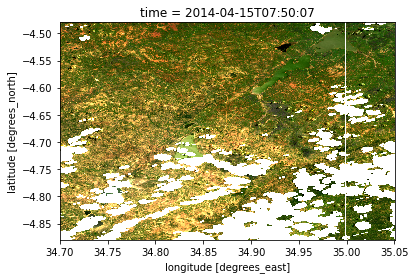

In [16]:
cleaned_dataset[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(robust=True)

## Classify water using Water Observations From Space (WOFS) algorithm

In [105]:
# wofs_arr = ignore_warnings(wofs_classify, cleaned_dataset).wofs
# wofs_arr = wofs_arr.where(wofs_arr != -9999, other=0)
# wofs_arr = wofs_arr.where(cloud_mask)

cleaned_dataset['wofs'] = wofs_arr



In [107]:
cleaned_dataset['ndvi'] = ((cleaned_dataset.nir - cleaned_dataset.red) / (cleaned_dataset.nir + cleaned_dataset.red))

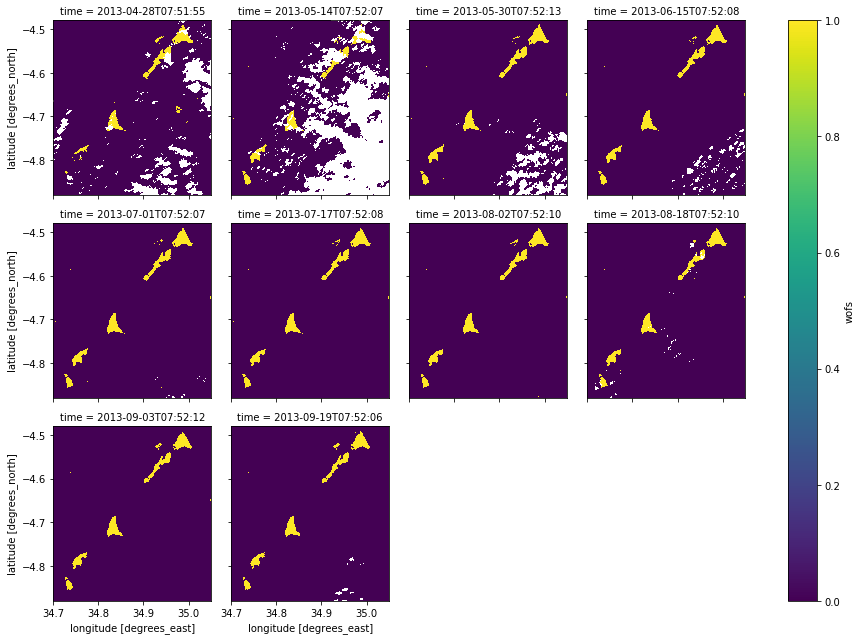

In [18]:
wofs_arr.isel(time=range(0, 10)).plot(col='time', col_wrap=4)

### Aggregate seasonally

In [221]:
seasonal_persistent = cleaned_dataset[['wofs', 'ndvi']].resample(time="QS-DEC").median(dim='time').fillna(0)
seasonal_persistent
# seasonal_persistent.plot(col='time', col_wrap=4)

<xarray.Dataset>
Dimensions:    (latitude: 1475, longitude: 1292, time: 20)
Coordinates:
  * time       (time) datetime64[ns] 2013-03-01 2013-06-01 ... 2017-12-01
  * longitude  (longitude) float64 34.7 34.7 34.7 34.7 ... 35.05 35.05 35.05
  * latitude   (latitude) float64 -4.48 -4.48 -4.481 ... -4.879 -4.88 -4.88
Data variables:
    wofs       (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ndvi       (time, latitude, longitude) float64 0.3765 0.6053 ... 0.0 0.0

In [222]:
# Compute Euclidean distance to edge of water for all non-water pixels
from scipy import ndimage as nd
distance = [nd.distance_transform_edt(i != 1) for i in seasonal_persistent.wofs]
distance_arrays = np.stack(distance)

# Do an approximate conversion to metres (1 decimal second at equator = 30.87 m)
distance_arrays = distance_arrays * 30.87

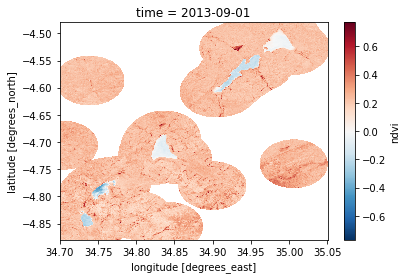

In [223]:
# Remove areas more distant than 5000 m from water
seasonal_nearwater = seasonal_persistent.where(distance_arrays < 5000)

# Plot example of array clipped to less than 5000km
seasonal_nearwater.isel(time=2).ndvi.plot()

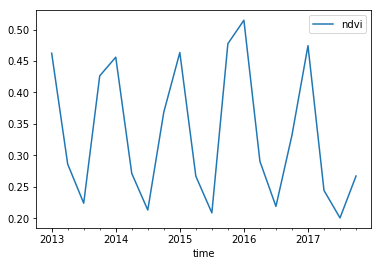

In [224]:
seasonal_ndvi_prop = (seasonal_nearwater.ndvi).mean(dim=['longitude', 'latitude']).to_dataframe()
seasonal_ndvi_prop.plot()

In [225]:
seasonal_ndvi_prop['season'] = seasonal_ndvi_prop.index.strftime('%B')
seasonal_ndvi_prop

,ndvi,season
time,,
2013-03-01,0.462292,March
2013-06-01,0.286051,June
2013-09-01,0.223893,September
2013-12-01,0.426289,December
2014-03-01,0.455999,March
2014-06-01,0.271114,June
2014-09-01,0.213006,September
2014-12-01,0.368666,December
2015-03-01,0.463393,March


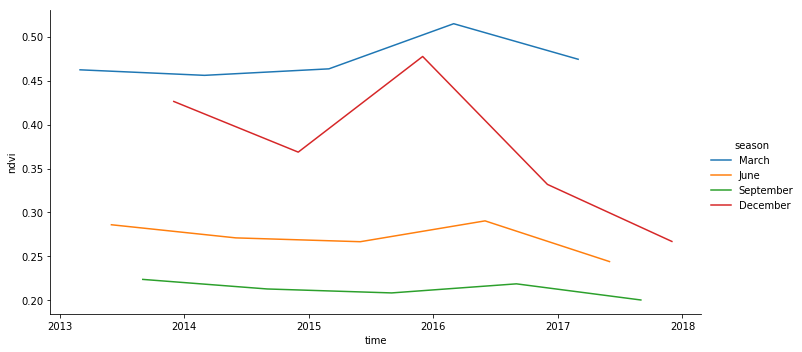

In [226]:
import seaborn as sns
fg = sns.FacetGrid(data=seasonal_ndvi_prop.reset_index(), hue='season', size=5, aspect=2)
fg.map(plt.plot, 'time', 'ndvi').add_legend()

In [212]:
seasonal_ndvi_prop.pivot(columns='season')

ndvi                              
season         April   January      July   October
time                                              
2013-04-01  0.680590       NaN       NaN       NaN
2013-07-01       NaN       NaN  0.177376       NaN
2013-10-01       NaN       NaN       NaN  0.024355
2014-01-01       NaN  0.826634       NaN       NaN
2014-04-01  0.641958       NaN       NaN       NaN
2014-07-01       NaN       NaN  0.121414       NaN
2014-10-01       NaN       NaN       NaN  0.047690
2015-01-01       NaN  0.695903       NaN       NaN
2015-04-01  0.604327       NaN       NaN       NaN
2015-07-01       NaN       NaN  0.043209       NaN
2015-10-01       NaN       NaN       NaN  0.192471
2016-01-01       NaN  0.758479       NaN       NaN
2016-04-01  0.728219       NaN       NaN       NaN
2016-07-01       NaN       NaN  0.129450       NaN
2016-10-01       NaN       NaN       NaN  0.035798
2017-01-01       NaN  0.539093       NaN       NaN
2017-04-01  0.519754       NaN       NaN       NaN
2017-07-01       NaN       NaN  0.029279       NaN
2017-10-01       NaN       NaN       NaN  0.052330

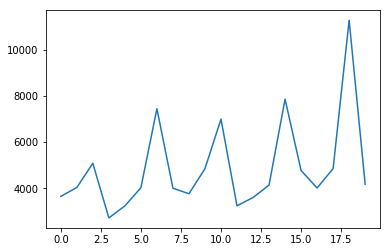

In [239]:
plt.plot(np.mean(distance_arrays, axis=(1,2)))